# Generate normalized allelic tables 

**Run with R_scRNAseq env**

### load packages

In [3]:
setwd("/staging/leuven/stg_00041/Adrian/TALON_JANISZEWSKI_XCR2/")

In [2]:
suppressPackageStartupMessages({
    library(Seurat)
    library(dplyr)
    library(readr)
    library(ggplot2)
    library(tidyr)
    suppressMessages(library(viridis))
})

Warning message:
"package 'Seurat' was built under R version 3.6.2"

In [4]:
# for reference:

ref_allelic <- read_csv("/staging/leuven/stg_00041/Adrian/AJ_0065.9-sc_allele_specific/AJ_0065.9c_allelic_norm_complete.csv")

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  .default = col_double(),
  gene = col_character(),
  RNA_id = col_character(),
  cell_type = col_character(),
  Xi = col_character(),
  Chr = col_character()
)
See spec(...) for full column specifications.


In [5]:
ref_allelic %>% head()

X1,gene,RNA_id,X,X129,Cast,sumReads,ratioPercent,ratioLog,Pseudotime,...,Xi,X2,cluster,cluster_replace,Chr,total_reads,mus_norm,cast_norm,ratio_norm,sum_norm
1,0610009B22Rik,Day_10_Xi_Mus_59,2323152,0,0,0,NA,NA,43.62880,...,Mus,226,0,2,chr11,88329,0.00000000,0.0000000,NA,0.0000000
2,0610009B22Rik,Day_10_Xi_Mus_15,1559376,0,0,0,NA,NA,48.75234,...,Mus,58,4,3,chr11,10125,0.00000000,0.0000000,NA,0.0000000
3,0610009B22Rik,Day_10_Xi_Mus_55,2259504,0,4,4,0.0001,-13.287712,44.71111,...,Mus,222,0,2,chr11,115942,0.00000000,0.2963941,0.0000000,0.2963941
4,0610009B22Rik,Day_12_Xi_Mus_85,5823792,1,7,8,0.1251,-2.806345,32.38629,...,Mus,397,1,1,chr11,142685,0.06773757,0.3991728,0.1450762,0.4669104
5,0610009B22Rik,Day_12_Xi_Mus_87,5855616,0,0,0,NA,NA,79.94168,...,Mus,391,5,4,chr11,202247,0.00000000,0.0000000,NA,0.0000000
6,0610009B22Rik,Day_9_Xi_Mus_26,7765056,4,0,4,1.0001,Inf,46.96879,...,Mus,11,0,2,chr11,181032,0.19963368,0.0000000,1.0000000,0.1996337


### I/O

In [15]:
io <- list()
io$allele <- "allele_specific/pre_processing/AJ_0065.9_allelic_bart_zeros_included.csv"
io$meta <- "input/AJ_0065_annotation.csv"
io$clusters <- "monocle/pseudotime_cluster_gene_normExpr.csv"
io$gene.metadata <- "/staging/leuven/stg_00041/genomes/mm10_GRCm38.p6/genemetadata.csv"

In [8]:
allelic <- read.csv(io$allele)
colnames(allelic)[2] <- "Name"
allelic$Name <- as.character(allelic$Name)

In [5]:
length(unique(allelic$Name))

[1] 662

In [10]:
allelic %>% head()

X,Name,gene,X129,Cast,sumReads,ratioPercent,ratioLog
0,Day_0_Xi_Mus_1,0610009B22Rik,0,0,0,NA,NA
1,Day_0_Xi_Mus_1,0610009O20Rik,0,0,0,NA,NA
2,Day_0_Xi_Mus_1,0610010F05Rik,0,0,0,NA,NA
3,Day_0_Xi_Mus_1,0610010K14Rik,0,0,0,NA,NA
4,Day_0_Xi_Mus_1,0610030E20Rik,0,0,0,NA,NA
5,Day_0_Xi_Mus_1,0610037L13Rik,0,0,0,NA,NA


In [36]:
meta <- read.csv(io$meta) %>% select(Name, Timepoint, Xi)

In [37]:
meta %>% head()

Name,Timepoint,Xi
Day_9_Xi_Mus_33,Day_9,Mus
Day_10_Xi_Mus_25,Day_10,Mus
Day_10_Xi_Mus_32,Day_10,Mus
Day_9_Xi_Mus_27,Day_9,Mus
Day_9_Xi_Mus_36,Day_9,Mus
Day_10_Xi_Mus_30,Day_10,Mus


In [17]:
clusters <- read.csv(io$clusters)

In [30]:
clusters <- clusters %>% 
                select(Name, Pseudotime, seurat_clusters_rename) %>%
                dplyr::distinct(Name, .keep_all = TRUE)
clusters$seurat_clusters_rename <- factor(clusters$seurat_clusters_rename, levels = c(0,1,2,3,4,5))

In [41]:
meta <- clusters %>% left_join(meta, by="Name")

Warning message:
"Column `Name` joining factors with different levels, coercing to character vector"

In [51]:
allele_meta <- allelic %>% merge(meta, by="Name", all.x=TRUE)
cells <- unique(meta$Name)
allele_meta <- allele_meta %>% filter(Name %in% cells)

In [48]:
chr_gene_map <- read_csv(io$gene.metadata)
chr_gene_map <- data.frame(chr_gene_map, row.names = chr_gene_map$X1)
chr_gene_map <- data.frame(chr_gene_map)
colnames(chr_gene_map) <- c("Geneid", "Chr")

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_character(),
  Chr = col_character()
)


In [49]:
head(chr_gene_map)

,Geneid,Chr
4933401J01Rik,4933401J01Rik,chr1
Gm26206,Gm26206,chr1
Xkr4,Xkr4,chr1
Gm18956,Gm18956,chr1
Gm37180,Gm37180,chr1
Gm37363,Gm37363,chr1


In [13]:
nrow(allele_meta)

[1] 8894808

In [53]:
allele_meta <- merge(allele_meta, chr_gene_map, by.x="gene", by.y="Geneid", all.x=TRUE)

Makeing the DF compatible with the code

In [57]:
allelic <- allele_meta %>% rename("RNA_id" = "Name")

In [58]:
allelic %>% head()

gene,RNA_id,X,X129,Cast,sumReads,ratioPercent,ratioLog,Pseudotime,seurat_clusters_rename,Timepoint,Xi,Chr
0610009B22Rik,Day_10_Xi_Mus_59,2323152,0,0,0,NA,NA,43.62880,2,Day_10,Mus,chr11
0610009B22Rik,Day_10_Xi_Mus_15,1559376,0,0,0,NA,NA,48.75234,3,Day_10,Mus,chr11
0610009B22Rik,Day_10_Xi_Mus_55,2259504,0,4,4,0.0001,-13.287712,44.71111,2,Day_10,Mus,chr11
0610009B22Rik,Day_12_Xi_Mus_85,5823792,1,7,8,0.1251,-2.806345,32.38629,1,Day_12,Mus,chr11
0610009B22Rik,Day_12_Xi_Mus_87,5855616,0,0,0,NA,NA,79.94168,4,Day_12,Mus,chr11
0610009B22Rik,Day_9_Xi_Mus_26,7765056,4,0,4,1.0001,Inf,46.96879,2,Day_9,Mus,chr11


In [59]:
a <- allelic %>% filter(Chr=="chrX")
a <-  unique(a$gene)
length(a)

[1] 441

#### Select only cells with same X inactivated to not mess with ratio's.

In [60]:
allelic <- allelic %>% filter(Xi=="Mus")

### Normalise

In [61]:
expr_cell <- allelic %>% select(RNA_id, sumReads) %>% group_by(RNA_id) %>% summarise(total_reads = sum(sumReads))

In [62]:
allelic <- left_join(allelic, expr_cell, by="RNA_id")

In [63]:
allelic$mus_norm <- log1p((allelic$X129/allelic$total_reads)*10000)
allelic$cast_norm <- log1p((allelic$Cast/allelic$total_reads)*10000)

In [64]:
allelic$ratio_norm <- (allelic$mus_norm/(allelic$mus_norm + allelic$cast_norm))
allelic$sum_norm <- allelic$mus_norm + allelic$cast_norm

In [23]:
head(allelic)

gene,RNA_id,X,X129,Cast,sumReads,ratioPercent,ratioLog,Pseudotime,cell_type,Xi,X2,cluster,cluster_replace,Chr,total_reads,mus_norm,cast_norm,ratio_norm,sum_norm
0610009B22Rik,Day_10_Xi_Mus_59,2323152,0,0,0,NA,NA,43.62880,Day_10,Mus,226,0,2,chr11,88329,0.00000000,0.0000000,NaN,0.0000000
0610009B22Rik,Day_10_Xi_Mus_15,1559376,0,0,0,NA,NA,48.75234,Day_10,Mus,58,4,3,chr11,10125,0.00000000,0.0000000,NaN,0.0000000
0610009B22Rik,Day_10_Xi_Mus_55,2259504,0,4,4,0.0001,-13.287712,44.71111,Day_10,Mus,222,0,2,chr11,115942,0.00000000,0.2963941,0.0000000,0.2963941
0610009B22Rik,Day_12_Xi_Mus_85,5823792,1,7,8,0.1251,-2.806345,32.38629,Day_12,Mus,397,1,1,chr11,142685,0.06773757,0.3991728,0.1450762,0.4669104
0610009B22Rik,Day_12_Xi_Mus_87,5855616,0,0,0,NA,NA,79.94168,Day_12,Mus,391,5,4,chr11,202247,0.00000000,0.0000000,NaN,0.0000000
0610009B22Rik,Day_9_Xi_Mus_26,7765056,4,0,4,1.0001,Inf,46.96879,Day_9,Mus,11,0,2,chr11,181032,0.19963368,0.0000000,1.0000000,0.1996337


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


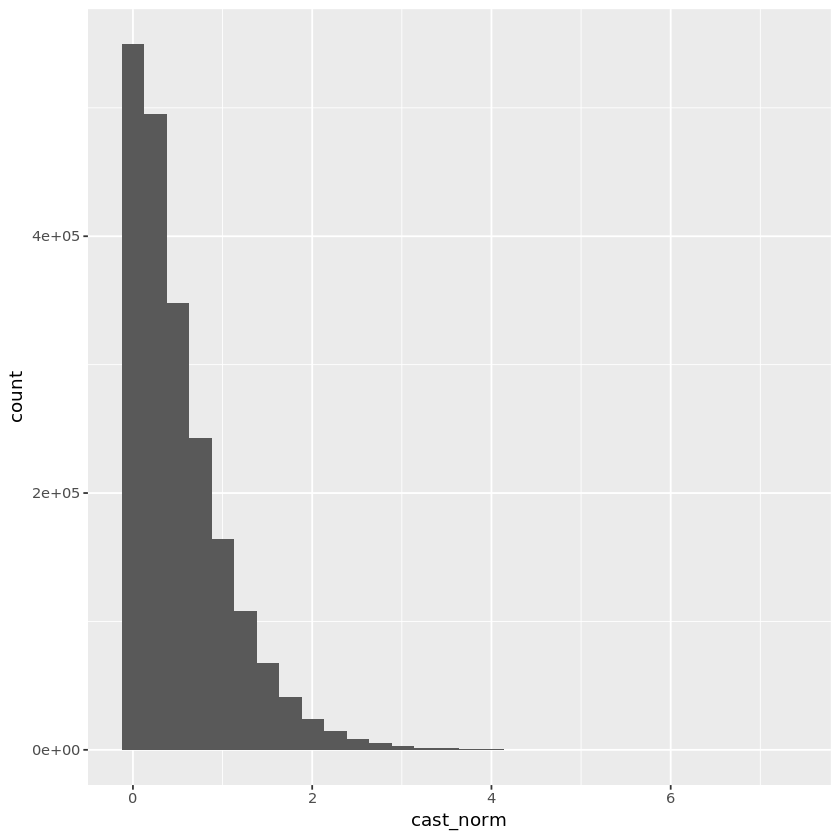

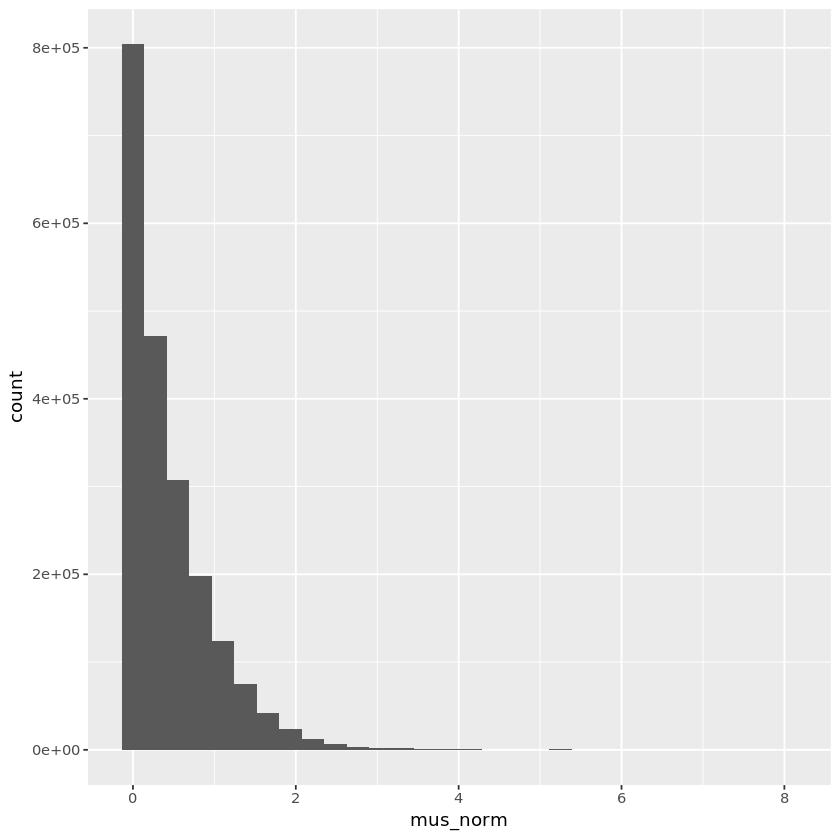

In [66]:
allelic %>% filter(sumReads > 0 ) %>% ggplot(aes(cast_norm)) + geom_histogram()
allelic %>% filter(sumReads > 0 ) %>% ggplot(aes(mus_norm)) + geom_histogram()

In [67]:
write.csv(allelic, "allele_specific/pre_processing/AJ_0065.9c_allelic_norm_complete.csv")